# Introduction
On May 3, 2017, Instacart released its first public dataset, **"[The Instacart Online Grocery Shopping Dataset 2017](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)"**.  Amazing!  Over **3 million** Instacart grocery orders from more than **200,000** users!  Take a look at their blog [post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) for details on this data science bonanza.

One thing that immediately caught my eye was the really cool chart about halfway through the article.  Here's the original:

![png](recreating-instacart-chart_files/time-of-day-vs-products-ordered.png)

It shows popular products purchased earliest in the day (green) and latest in the day (red).  Funny to see that 24 of the 25 latest ordered products are all ice cream.

Let's see if we can recreate this chart!

## Contents
1. [Import Libraries](#1-import-libraries)
2. [Read Data](#2-read-data)
3. [Clean & Organize](#3-clean--organize)
4. [Reduce the Problem Size](#4-reduce-the-problem-size)
5. [Product and Hour of Day Distribution](#5-product-and-hour-of-day-distribution)
6. [Morning & Afternoon Products](#6-morning--afternoon-products)
7. [Plotting](#7-plotting)
8. [Final Result](#8-final-result)
9. [Conclusion](#conclusion)

# 1. Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.width', 1000)

# 2. Read Data
You can download the original data files [here](https://www.instacart.com/datasets/grocery-shopping-2017).

To keep things simple (and reduce memory usage) when reading the data files, I kept only the columns required for the chart.

In [2]:
path = './data/instacart/'

csv_orders = os.path.join(path, 'orders.csv')
csv_order_products_prior = os.path.join(path, 'order_products__prior.csv')
csv_order_products_train = os.path.join(path, 'order_products__train.csv')
csv_products = os.path.join(path, 'products.csv')

df_orders = pd.read_csv(csv_orders, usecols=['order_id', 'eval_set', 'order_hour_of_day'])
df_order_products_prior = pd.read_csv(csv_order_products_prior, usecols=['order_id', 'product_id'])
df_order_products_train = pd.read_csv(csv_order_products_train, usecols=['order_id', 'product_id'])
df_products = pd.read_csv(csv_products, usecols=['product_id', 'product_name'])


# 3. Clean & Organize
The dataset is split into multiple files (see the [data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) for file and content descriptions).  So first a little clean-up:

In [3]:
# remove any rows referring to the test set
df_orders = df_orders[df_orders.eval_set != 'test']

# drop the eval_set column
df_orders = df_orders.drop(['eval_set'], axis=1)

# concatenate the _prior and _train datasets
df_order_products = pd.concat([df_order_products_prior, df_order_products_train])

# expand every order_id with the list of product_ids in that order_id
df = df_orders.merge(df_order_products, on='order_id')
print(df.head())

   order_id  order_hour_of_day  product_id
0   2539329                  8         196
1   2539329                  8       14084
2   2539329                  8       12427
3   2539329                  8       26088
4   2539329                  8       26405


# 4. Reduce the Problem Size

There are almost 50,000 unique `product_id` in our dataset.  We can reduce the size of this dataset without affecting our chart by just keeping the most common products.  I originally chose to keep the top 5,000 products, but after seeing the original source code (see the [Resources](#Resources)) I changed it to the top 2,000.

In [4]:
## Keep only the top 2000 products
top_products = pd.DataFrame({'total_count': df.groupby('product_id').size()}).sort_values('total_count', ascending=False).reset_index()[:2000]
top_products = top_products.merge(df_products, on='product_id')
print(top_products.head())

   product_id  total_count            product_name
0       24852       491291                  Banana
1       13176       394930  Bag of Organic Bananas
2       21137       275577    Organic Strawberries
3       21903       251705    Organic Baby Spinach
4       47209       220877    Organic Hass Avocado


# 5. Product and Hour of Day Distribution
For each of the top 2,000 products, we need to calculate the mean hour of the day that product was purchased in.  In other words, we need to figure at what time each line in the chart peaks.  From there, we can then find the products with the earliest and latest "peaks" for our chart.

In [5]:
# keep only observations that have products in top_products
df = df.loc[df['product_id'].isin(top_products.product_id)]

For each `product_id`, count how many orders were placed at each hour and what % this count represents.

In [6]:
product_orders_by_hour = pd.DataFrame({'count': df.groupby(['product_id', 'order_hour_of_day']).size()}).reset_index()
product_orders_by_hour['pct'] = product_orders_by_hour.groupby('product_id')['count'].apply(lambda x: x/x.sum()*100)
print(product_orders_by_hour.head(24))

    product_id  order_hour_of_day  count       pct
0           34                  0     23  0.339283
1           34                  1     18  0.265526
2           34                  2     11  0.162266
3           34                  3      5  0.073757
4           34                  4      5  0.073757
5           34                  5     15  0.221272
6           34                  6     57  0.840832
7           34                  7    202  2.979791
8           34                  8    402  5.930078
9           34                  9    509  7.508482
10          34                 10    603  8.895117
11          34                 11    542  7.995280
12          34                 12    464  6.844667
13          34                 13    547  8.069037
14          34                 14    557  8.216551
15          34                 15    582  8.585337
16          34                 16    548  8.083788
17          34                 17    472  6.962679
18          34                 

Finally, we calculate the mean hour for each product:

In [7]:
mean_hour = pd.DataFrame({'mean_hour': product_orders_by_hour.groupby('product_id').apply(lambda x: sum(x['order_hour_of_day'] * x['count'])/sum(x['count']))}).reset_index()
print(mean_hour.head())

   product_id  mean_hour
0          34  13.511285
1          45  13.398624
2          79  13.502530
3         116  12.516822
4         117  13.392173


# 6. Morning and Afternoon Products

With our calculations, we are ready to find out which products belong in our chart.

In [8]:
morning = mean_hour.sort_values('mean_hour')[:25]
morning = morning.merge(df_products, on='product_id')
print(morning.head())

   product_id  mean_hour                           product_name
0        9292  11.767279        Half And Half Ultra Pasteurized
1       46562  11.898340  Sweet & Salty Nut Granola Bars Peanut
2       45051  12.004019                                Pub Mix
3       36472  12.049459            Nutri Grain Bars Multi Pack
4       37710  12.059043                              Trail Mix


In [9]:
afternoon = mean_hour.sort_values('mean_hour', ascending=False)[:25]
afternoon = afternoon.merge(df_products, on='product_id')
print(afternoon.head())

   product_id  mean_hour                  product_name
0       30668  14.526986      Half Baked Frozen Yogurt
1       45541  14.526299  The Tonight Dough™ Ice Cream
2       45681  14.394912    Americone Dream® Ice Cream
3       46175  14.388942         Half Baked® Ice Cream
4       14335  14.373308         Phish Food® Ice Cream


Fantastic!  Our morning and afternoon product list matches up with the Instacart chart.

# 7. Plotting
Let's break our `product_orders_by_hour` into morning and afternoon groups for ease of plotting.

In [10]:
morning_pct = product_orders_by_hour.merge(morning, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'])
afternoon_pct = product_orders_by_hour.merge(afternoon, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'], ascending=False)

Next we'll get the names of each product in the morning and afternoon groups in order to recreate the product list in the original chart.  For some reason I had to change one of the product names to match the name in the Instacart chart.

In [11]:
# get list of morning and afteroon product names
morning_product_names = list(morning_pct['product_name'].unique())
morning_product_names = '\n'.join(morning_product_names)
afternoon_product_names = list(afternoon_pct['product_name'].unique())
afternoon_product_names = '\n'.join(afternoon_product_names)

# hack to remove 'Variety Pack' from Orange & Lemon Flavor Variety Pack Sparkling Fruit Beverage
morning_product_names = morning_product_names.replace('Variety Pack ', '')

# 8. Final Result

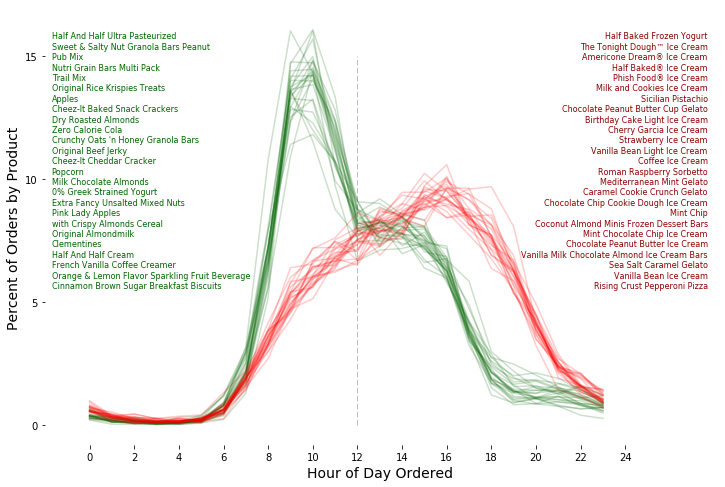

In [12]:
# Figure Size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot
morning_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                       y='pct', 
                                       ax=ax, 
                                       legend=False,
                                       alpha=0.2,
                                       aa=True,
                                       color='darkgreen',
                                       linewidth=1.5,)
afternoon_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                         y='pct', 
                                         ax=ax, 
                                         legend=False,
                                         alpha=0.2,
                                         aa=True,
                                         color='red',
                                         linewidth=1.5,)

# Aesthetics
# Margins
plt.margins(x=0.5, y=0.05)

# Hide spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Labels
label_font_size = 14
plt.xlabel('Hour of Day Ordered', fontsize=label_font_size)
plt.ylabel('Percent of Orders by Product', fontsize=label_font_size)

# Tick Range
tick_font_size = 10
ax.tick_params(labelsize=tick_font_size)
plt.xticks(range(0, 25, 2))
plt.yticks(range(0, 16, 5))
plt.xlim([-2, 28])

# Vertical line at noon
plt.vlines(x=12, ymin=0, ymax=15, alpha=0.5, color='gray', linestyle='dashed', linewidth=1.0)

# Text
text_font_size = 8
ax.text(0.01, 0.95, morning_product_names,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='darkgreen', fontsize=text_font_size)
ax.text(0.99, 0.95, afternoon_product_names,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='darkred', fontsize=text_font_size);

# Conclusion
In recreating the Instacart chart, I had a lot of fun and learned a bunch about `matplotlib`, and I hope you did too.  Many thanks to **Instacart** for releasing this dataset and to **Nigel Carpenter** for sharing his recreation of this chart.  It's nice to see other's workflows, and I learned a bit of **R** too.  I find I quite like the `magrittr %>%` style of writing.

Until next time, keep exploring!

> Have a question about this topic, or a suggestion for a future topic?  Please, leave a comment below!
{:.blockquote}

### Resources
- [The Instacart Online Grocery Shopping Dataset 2017](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) blog post
- Instacart's Jeremy Stanley's [source code](https://gist.github.com/jeremystan/b3be353189dd0a8053e4a4b36991694a)
- Nigel Carpenter's Kaggle [kernel](https://www.kaggle.com/nigelcarpenter/recreating-the-products-by-hour-chart) recreating the chart in R

### Citation
> "The Instacart Online Grocery Shopping Dataset 2017", Accessed from [https://www.instacart.com/datasets/grocery-shopping-2017](https://www.instacart.com/datasets/grocery-shopping-2017) on May 17, 2017
{:.blockquote}